La très jeune start-up de l'AgriTech, nommée  "Fruits!", qui cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.
Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.


In [1]:
# L'exécution de cette cellule démarre l'application Spark
# Changer le kernel en celui de spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1675810844606_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Affichage des informations sur la session en cours et liens vers Spark UI :

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1675445923042_0001,pyspark,idle,Link,Link,None,✔


Les packages nécessaires ont été installé via l'étape de bootstrap à l'instanciation du serveur.

**Import des librariries**

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import pathlib
import PIL
import time
import matplotlib.pyplot as plt

# For tensorflow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# For Pyspark
from pyspark.ml.feature import StandardScaler, StringIndexer
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import PCA as PCAml
from pyspark.sql.types import *

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Définition des PATH pour charger les images et enregistrer les résultats**
Nous accédons directement à nos données sur S3 comme si elles étaient stockées localement.

In [4]:
PATH = 's3://p8-hanane-maghlazi'
PATH_Data = PATH+'/Fruits'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://p8-hanane-maghlazi
PATH_Data:   s3://p8-hanane-maghlazi/Fruits
PATH_Result: s3://p8-hanane-maghlazi/Results

**Chargement des images :**

Chargement des données:
Importer les images dans un dataframe pandas UDF

- Les images sont chargées au format binaire, pour plus de souplesse dans la façon de prétraiter les images
- charger uniquement les fichiers dont l'extension est jpg

In [5]:
start = time.time()

images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)
end = time.time()
print(f'Lecture des images : {end - start:0.2f}s')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Lecture des images : 3.08s

- Affichage des 5 premières images contenant :
  - le path de l'image

  - la date et heure de sa dernière modification : modificationtime

  - sa longueur : length

  - son contenu encodé en valeur hexadécimal: content

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://p8-hanane-ma...|2023-01-17 09:54:15|  5452|[FF D8 FF E0 00 1...|
|s3://p8-hanane-ma...|2023-01-17 09:54:15|  5423|[FF D8 FF E0 00 1...|
|s3://p8-hanane-ma...|2023-01-17 09:54:14|  5409|[FF D8 FF E0 00 1...|
|s3://p8-hanane-ma...|2023-01-17 09:54:14|  5397|[FF D8 FF E0 00 1...|
|s3://p8-hanane-ma...|2023-01-17 09:54:14|  5386|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

Je ne conserve que le path de l'image et j'ajoute
une colonne contenant les labels de chaque image :

In [6]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------+------+
|path                                            |label |
+------------------------------------------------+------+
|s3://p8-hanane-maghlazi/Fruits/Orange/1_100.jpg |Orange|
|s3://p8-hanane-maghlazi/Fruits/Orange/0_100.jpg |Orange|
|s3://p8-hanane-maghlazi/Fruits/Orange/11_100.jpg|Orange|
|s3://p8-hanane-maghlazi/Fruits/Orange/10_100.jpg|Orange|
|s3://p8-hanane-maghlazi/Fruits/Orange/2_100.jpg |Orange|
+------------------------------------------------+------+
only showing top 5 rows

None

**Préparation du modèle :**

- Nous chargeons le modèle MobileNetV2 avec les poids précalculés issus d'imagenet et en spécifiant le format de nos images en entrée

Nous créons un nouveau modèle avec:

en entrée : l'entrée du modèle MobileNetV2

en sortie : l'avant dernière couche du modèle MobileNetV2

In [7]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14540800/14536120 [==============================] - 1s 0us/step

In [8]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

**Traitement de diffusion des poids du modèle Tensorflow sur les clusters (broadcast des “weights” du modèle)**

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. 

Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser 
ensuite les poids aux différents workeurs.

In [9]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Mettre le tout en fonction : 

In [10]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF : 

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

In [11]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1675810844606_0001/container_1675810844606_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

Exécuter la featurisation sur l'ensemble de notre DataFrame Spark : 

In [12]:
start=time.time()
features_df = images.repartition(10).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )
end = time.time()
print(f'Extraction des features : {end - start:0.2f}s')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Extraction des features : 0.10s

In [14]:
features_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

In [15]:
features_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+--------------------+
|                path|          label|            features|
+--------------------+---------------+--------------------+
|s3://p8-hanane-ma...|         Orange|[0.033774916, 0.0...|
|s3://p8-hanane-ma...|Apple Pink Lady|[0.6022466, 0.032...|
|s3://p8-hanane-ma...|         Orange|[0.29246765, 0.0,...|
|s3://p8-hanane-ma...|           Kiwi|[1.3506836, 0.003...|
|s3://p8-hanane-ma...|Apple Pink Lady|[0.34955275, 0.0,...|
+--------------------+---------------+--------------------+
only showing top 5 rows

**Réduction de dimension de type PCA en PySpark :**

In [13]:
# Transform array to vector for PCA
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
features_vect = features_df.select('path', 'label', ud_f('features').alias('features_vec'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
features_vect.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+--------------------+
|                path|          label|        features_vec|
+--------------------+---------------+--------------------+
|s3://p8-hanane-ma...|         Orange|[0.09117154031991...|
|s3://p8-hanane-ma...|         Orange|[0.37549969553947...|
|s3://p8-hanane-ma...|Apple Pink Lady|[0.06314041465520...|
|s3://p8-hanane-ma...|Apple Pink Lady|[0.60224658250808...|
|s3://p8-hanane-ma...|Apple Pink Lady|[0.21740919351577...|
+--------------------+---------------+--------------------+
only showing top 5 rows

Normalisation des features

In [14]:
# Standardiser les données avant la PCA
standardizer = StandardScaler(withMean=True, withStd=True,inputCol="features_vec", outputCol="features_scaled")
model = standardizer.fit(features_vect)
result = model.transform(features_vect)
features_vect_scaled= result.select('path', 'label', 'features_scaled')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
features_vect_scaled.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+--------------------+
|                path|          label|     features_scaled|
+--------------------+---------------+--------------------+
|s3://p8-hanane-ma...|         Orange|[-1.1218479982768...|
|s3://p8-hanane-ma...|         Orange|[-0.3548661635099...|
|s3://p8-hanane-ma...|Apple Pink Lady|[-1.1974626139883...|
|s3://p8-hanane-ma...|Apple Pink Lady|[0.25678885623492...|
|s3://p8-hanane-ma...|Apple Pink Lady|[-0.7813189824638...|
+--------------------+---------------+--------------------+
only showing top 5 rows

In [15]:
# PCA 
pca = PCAml(k=50, inputCol="features_scaled", outputCol="features_pca")
model = pca.fit(features_vect_scaled)
features_df_pca = model.transform(features_vect_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
model.explainedVariance.sum()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9999999999999989

In [ ]:
# Bar plot of explained_variance
plt.bar(
    range(1,len(model.explainedVariance)+1),
    model.explainedVariance
    )
 
plt.plot(
    range(1,len(model.explainedVariance )+1),
    np.cumsum(model.explainedVariance),
    c='red',
    )
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

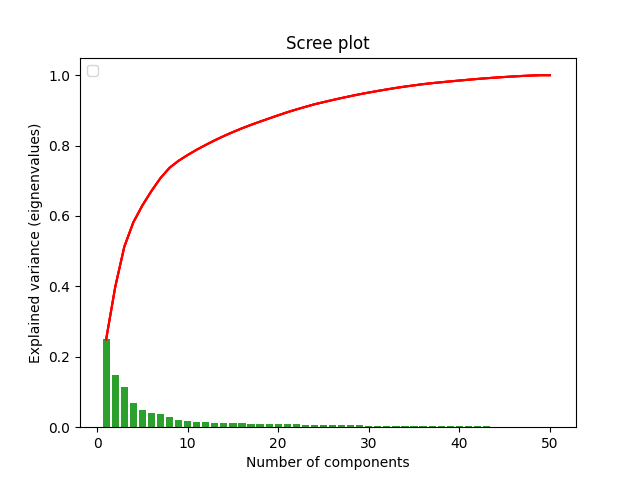

In [21]:
%matplot plt

In [18]:
features_df_pca.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+--------------------+--------------------+
|                path|          label|     features_scaled|        features_pca|
+--------------------+---------------+--------------------+--------------------+
|s3://p8-hanane-ma...|         Orange|[-1.1218479982768...|[8.18036660117578...|
|s3://p8-hanane-ma...|         Orange|[-0.3548661635099...|[6.90666432619188...|
|s3://p8-hanane-ma...|Apple Pink Lady|[-1.1974626139883...|[13.5566886964658...|
|s3://p8-hanane-ma...|Apple Pink Lady|[0.25678885623492...|[15.9440812907747...|
|s3://p8-hanane-ma...|Apple Pink Lady|[-0.7813189824638...|[14.6141329175917...|
+--------------------+---------------+--------------------+--------------------+
only showing top 5 rows

In [19]:
# Je ne garde que les features après PCA
features_df_pca= features_df_pca.select('path', 'label', 'features_pca')
features_df_pca.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+--------------------+
|                path|          label|        features_pca|
+--------------------+---------------+--------------------+
|s3://p8-hanane-ma...|         Orange|[8.18036660117578...|
|s3://p8-hanane-ma...|         Orange|[6.90666432619187...|
|s3://p8-hanane-ma...|Apple Pink Lady|[13.5566886964658...|
|s3://p8-hanane-ma...|Apple Pink Lady|[15.9440812907747...|
|s3://p8-hanane-ma...|Apple Pink Lady|[14.6141329175917...|
+--------------------+---------------+--------------------+
only showing top 5 rows

In [20]:
features_df_pca.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features_pca: vector (nullable = true)

In [21]:
# vector to array

features_df_pca = features_df_pca.withColumn("features_pca", vector_to_array("features_pca"))
features_df_pca = features_df_pca.select('path', 'label', 'features_pca')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
features_df_pca.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features_pca: array (nullable = false)
 |    |-- element: double (containsNull = false)

In [25]:
features_df_pca.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+--------------------+
|                path|          label|        features_pca|
+--------------------+---------------+--------------------+
|s3://p8-hanane-ma...|         Orange|[8.18036660117578...|
|s3://p8-hanane-ma...|         Orange|[6.90666432619188...|
|s3://p8-hanane-ma...|Apple Pink Lady|[13.5566886964658...|
|s3://p8-hanane-ma...|Apple Pink Lady|[15.9440812907747...|
|s3://p8-hanane-ma...|Apple Pink Lady|[14.6141329175917...|
+--------------------+---------------+--------------------+
only showing top 5 rows

In [23]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://p8-hanane-maghlazi/Results

#### Enregistrement des données : 

In [24]:
# Enregistrement des données traitées au format "parquet" :
start=time.time()

features_df_pca.write.mode("overwrite").parquet(PATH_Result)

end = time.time()
print(f'Enregistrement sous format parquet: {end - start:0.2f}s')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Enregistrement sous format parquet: 37.51s

- Chargement des données enregistrées et validation du résultat: 

In [25]:
# Lecture du fichier sous format dataframe

df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                       features_pca
0   s3://p8-hanane-maghlazi/Fruits/Orange/11_100.jpg  ...  [8.18036660117578, -6.0156945862910405, 20.805...
1   s3://p8-hanane-maghlazi/Fruits/Orange/10_100.jpg  ...  [6.906664326191878, -5.314968775249669, 17.160...
2  s3://p8-hanane-maghlazi/Fruits/Apple Pink Lady...  ...  [13.556688696465867, -4.007761615703691, 0.956...
3  s3://p8-hanane-maghlazi/Fruits/Apple Pink Lady...  ...  [15.944081290774754, -4.7202834695502975, -0.8...
4  s3://p8-hanane-maghlazi/Fruits/Apple Pink Lady...  ...  [14.614132917591713, -4.129271611248213, -0.56...

[5 rows x 3 columns]

In [27]:
# Export sous csv
start=time.time()

df_pca = features_df_pca.toPandas()
df_pca.to_csv("s3://p8-hanane-maghlazi/Results/result.csv",index=False)

end = time.time()
print(f'Enregistrement du fichier csv: {end - start:0.2f}s')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Enregistrement du fichier csv: 19.72s

In [28]:
# Lecture du fichier csv
df_final = pd.read_csv("s3://p8-hanane-maghlazi/Results/result.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
df_final.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                       features_pca
0   s3://p8-hanane-maghlazi/Fruits/Orange/11_100.jpg  ...  [8.18036660117578, -6.0156945862910405, 20.805...
1   s3://p8-hanane-maghlazi/Fruits/Orange/10_100.jpg  ...  [6.906664326191878, -5.314968775249669, 17.160...
2  s3://p8-hanane-maghlazi/Fruits/Apple Pink Lady...  ...  [13.556688696465867, -4.007761615703691, 0.956...
3  s3://p8-hanane-maghlazi/Fruits/Apple Pink Lady...  ...  [15.944081290774754, -4.7202834695502975, -0.8...
4  s3://p8-hanane-maghlazi/Fruits/Apple Pink Lady...  ...  [14.614132917591713, -4.129271611248213, -0.56...

[5 rows x 3 columns]